In [1]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Activation, Dropout, concatenate)
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import collections
import tensorflow as tf
import time
sys.path.append('./*')
sys.path=list(set(sys.path))

from model.keras_models import create_dense_layers, inst_layers, sampling
from module_DTI.default_load import *
from module_DTI.utils import *

config = collections.namedtuple('config', ['Dataset'])
dict_directories = {'dir_ROOT': './dataset/final', }
dict_directories.update({
    'DTI_adjmat': dict_directories['dir_ROOT'] + '/drug-target_mat.tsv',
    'drug': dict_directories['dir_ROOT'] + '/drug_descriptor.tsv',
    'target': dict_directories['dir_ROOT'] + '/protein_descriptor.tsv'
})
config_Dataset = {
        'dict_directories': dict_directories,
        'neg_to_pos_ratio': 1,
        'split_ratio': 0.8,
        'pos_filename': 'pos_sample.txt',
        'neg_filename': 'neg_sample_1.txt',
}
save_path='./model/model_saved/'
checkpoint_path='./model/model_checkpoints/'
config.Dataset = config_Dataset

Using TensorFlow backend.


In [2]:
opt_verbose_dataset=0
opt_verbose_training=0
opt_loss_loc=0
opt_acc_loc=1
DTI=load_DTI(config,verbose=opt_verbose_dataset)
load_pos_neg_samples(config,DTI)
unlabel_file='10times.npy'
unlabel_data=load_unlabel(config,unlabel_file)

--------------------------------------------------------
Load DTI data.
--------------------------------------------------------
Load existing positive & negative sample files.
# of positive samples: 9592
# of features of a positive sample: 1627

# of negative samples: 9592
# of features of a negative sample: 1627

Load existing unlabel sample file.
Complete loading all default dataset & variables.

--------------------------------------------------------


In [5]:
pair_ae=keras.models.load_model(save_path+'pair_dim500_final.hdf')
# pair_ae=keras.models.load_model(save_path+'pair_dim500_allsigmoid.hdf')
pair_layer=pair_ae.layers[1].layers[1:]
drug_target_intput=Input(shape=(1627,),name='DT_input')
drug_target_vector=inst_layers(pair_layer,drug_target_intput)
M1=Model(inputs=drug_target_intput,outputs=drug_target_vector)

In [9]:
pair_layer[3].activation

<function keras.activations.linear(x)>

In [3]:
train_x=unlabel_data

index = np.arange(len(train_x))
np.random.shuffle(index)
split_ratio=0.5
n_train=int(np.shape(train_x)[0]*split_ratio)
index_range1=index[:n_train]
index_range2=index[n_train:]
unlabel_train_x=train_x[index_range1]
unlabel_test_x=train_x[index_range2]
print(unlabel_train_x.shape)
print(unlabel_test_x.shape)

(86320, 1627)
(86320, 1627)


In [4]:
input_dim = int(np.shape(unlabel_train_x)[1])
latent_dim=500
epochs=100
batch_size=500

In [10]:
x_in =Input(shape=(input_dim,), name='x_Input')
x = x_in
enc_layers = [
    create_dense_layers(stage='enc', units=1000,
                        activation='relu',dropout=0.2,
                        batch_normalization='on'),
#     create_dense_layers(stage=s+'enc_2', units=750,activation='relu',dropout=0.3),
    
]
_enc=inst_layers(enc_layers,x)
z = Dense(latent_dim,activation='linear',name='latent_variable')(_enc)
encoder = Model(x_in, z, name='encoder')

z_inputs = Input(shape=(latent_dim,), name='decoder_Input')
dec_layers = [
    create_dense_layers(stage='dec', units=1000,
                        activation='relu',dropout=0.2,
                        batch_normalization='on'),
#     create_dense_layers(stage=s+'dec_2',units=750,activation='relu',dropout=0.3),
]
_dec=inst_layers(dec_layers,z_inputs)
outputs = Dense(input_dim,name='x_Reconstructed',
                activation='sigmoid')(_dec)
decoder = Model(z_inputs, outputs, name='decoder')

ae= Model(x_in, decoder(encoder(x_in)), name='autoencoder')
ae.compile(loss='mse', optimizer=Adam())
# hist=ae.fit(x=unlabel_train_x, y=unlabel_train_x,
#             epochs=2,batch_size=batch_size,
#             shuffle=True,verbose=2,
#             validation_data=(unlabel_test_x, unlabel_test_x),
#             callbacks=[EarlyStopping()])

In [11]:
history_train=[]
history_test=[]
import time
for epoch in range(epochs):
    start=time.time()
    index=np.arange(len(unlabel_train_x))
    np.random.shuffle(index)
    batches=len(unlabel_train_x)//batch_size
    for i in range(batches):
        index_range =  index[i * batch_size:(i+1) * batch_size]
        loss = ae.train_on_batch(
            x=[unlabel_train_x[index_range]],
            y=[unlabel_train_x[index_range]])

    l = ae.evaluate(
        x=[unlabel_train_x],
        y=[unlabel_train_x],
        verbose=opt_verbose_training)
    l_test = ae.evaluate(
        x=[unlabel_test_x],
        y=[unlabel_test_x],
        verbose=opt_verbose_training)
    end=time.time()
    history_train.append(l)
    history_test.append(l_test)
    print('Epoch ' +str(epoch))
    print('train loss, validation loss: %.7f, %.7f' % (l,l_test))

Epoch 0
train loss, validation loss: 0.0084705, 0.0084957
Epoch 1
train loss, validation loss: 0.0070836, 0.0071223
Epoch 2
train loss, validation loss: 0.0059908, 0.0060366
Epoch 3
train loss, validation loss: 0.0046874, 0.0047384
Epoch 4
train loss, validation loss: 0.0035248, 0.0035726
Epoch 5
train loss, validation loss: 0.0031215, 0.0031686
Epoch 6
train loss, validation loss: 0.0027017, 0.0027481
Epoch 7
train loss, validation loss: 0.0025533, 0.0025978
Epoch 8
train loss, validation loss: 0.0023407, 0.0023833
Epoch 9
train loss, validation loss: 0.0022462, 0.0022881
Epoch 10
train loss, validation loss: 0.0021464, 0.0021878
Epoch 11
train loss, validation loss: 0.0020904, 0.0021324
Epoch 12
train loss, validation loss: 0.0019613, 0.0020008
Epoch 13
train loss, validation loss: 0.0019785, 0.0020175
Epoch 14
train loss, validation loss: 0.0019101, 0.0019494
Epoch 15
train loss, validation loss: 0.0018749, 0.0019128
Epoch 16
train loss, validation loss: 0.0018068, 0.0018433
Epoch 1

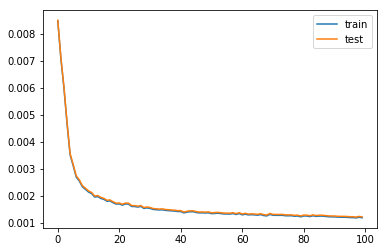

In [12]:
plot_epoch_loss_w_test(np.transpose([history_train]),
                       np.transpose([history_test]),loss_loc=0)


In [13]:
with open('AE_loss_test.txt','w') as f:
    for kk in list(np.concatenate((history_train,history_test))):
        f.write(str(kk)+' ')

In [14]:
ae.save(save_path+'pair_dim'+str(latent_dim)+'_20190520.hdf')
# ae_dataset.save_rest_sample(filename=config.Save['save_model_path']+'_1e4_1e3_rest.txt')

In [9]:
# ind_0=[]
# ind_1=[]
# for ind,value in enumerate(_test_y):
#     if list(value)==[1,0]:
#         ind_0.append(ind)
#     else:
#         ind_1.append(ind)
        
# from mpl_toolkits.mplot3d import Axes3D
# fig=plt.figure()
# ax = Axes3D(fig)
# ax.scatter(xs=reduced_x[ind_0,0],ys=reduced_x[ind_0,1],zs=reduced_x[ind_0,2])
# ax.scatter(xs=reduced_x[ind_1,0],ys=reduced_x[ind_1,1],zs=reduced_x[ind_1,2])